In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomocupy.magnification import M
from holotomocupy.shift import S, ST, registration_shift
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
import holotomocupy.chunking as chunking
from holotomocupy.utils import *


%matplotlib inline

chunking.global_chunk = 20

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis

# ID16a setup
ndist = 1

detector_pixelsize = 3e-6
energy = 17.05  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8

## Read data

In [3]:
data00 = np.zeros([ntheta, ndist, n, n], dtype='float32')
ref00 = np.zeros([1, ndist, n, n], dtype='float32')

for k in range(ndist):
    data00[:, k] = dxchange.read_tiff(f'data/data_3d_ald_{n}_{k}.tiff')[:ntheta]
    ref00[:, k] = dxchange.read_tiff(f'data/ref_3d_ald_{n}_{k}.tiff')
shifts = np.load('data/shifts.npy')[:ntheta, :ndist]
shifts_drift_init = np.load('data/shifts_drift.npy')[:ntheta, :ndist]
shifts_ref_init = np.load('data/shifts_ref.npy')[:ntheta, :ndist]
shifts_ref0_init = np.load('data/shifts_ref0.npy')[:, :ndist]

# Find shifts of reference images

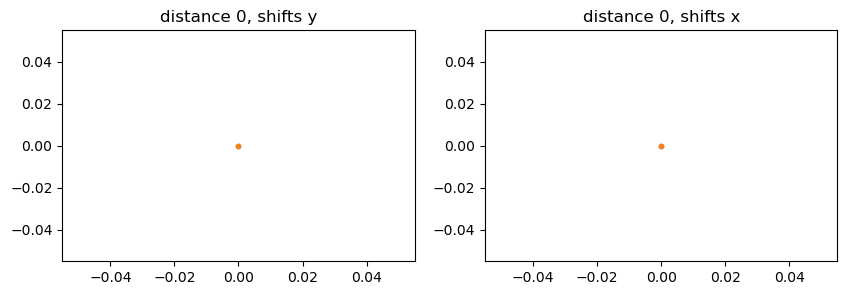

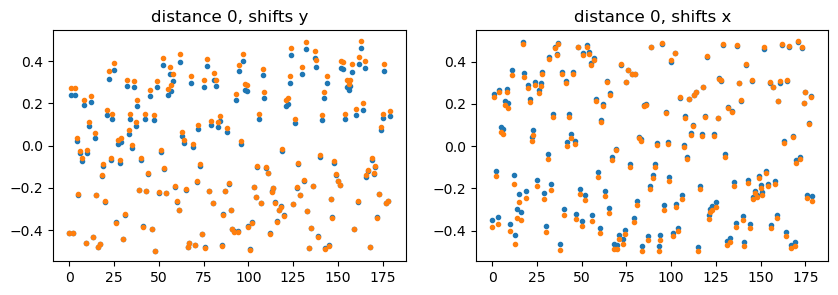

In [4]:
shifts_ref0 = np.zeros([1, ndist, 2], dtype='float32')
for k in range(ndist):
    shifts_ref0[:, k] = registration_shift(ref00[:, k], ref00[:, 0], upsample_factor=1000)
    
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
im = axs[0].plot(shifts_ref0[0, :, 0], '.')
im = axs[0].plot(shifts_ref0_init[0, :, 0], '.')
axs[0].set_title(f'distance {k}, shifts y')
im = axs[1].plot(shifts_ref0[0, :, 1], '.')
im = axs[1].plot(shifts_ref0_init[0, :, 1], '.')
axs[1].set_title(f'distance {k}, shifts x')
plt.show()


shifts_ref = np.zeros([ntheta, ndist, 2], dtype='float32')
for k in range(ndist):
    im = np.tile(ref00[0, 0], [ntheta, 1, 1])
    shifts_ref[:, k] = registration_shift(data00[:, k], im, upsample_factor=1000)
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    im = axs[0].plot(shifts_ref[:, k, 0], '.')
    im = axs[0].plot(shifts_ref_init[:, k, 0], '.')
    axs[0].set_title(f'distance {k}, shifts y')
    im = axs[1].plot(shifts_ref[:, k, 1], '.')
    im = axs[1].plot(shifts_ref_init[:, k, 1], '.')
    axs[1].set_title(f'distance {k}, shifts x')
    plt.show()

### Assuming the shifts are calculated, shifts refs back

In [5]:
data0 = data00.copy()
ref0 = ref00.copy()
# shifted refs for correction
for k in range(ndist):
    # shift refs back
    ref0[:, k] = ST(ref0[:, k].astype('complex64'), shifts_ref0[:, k]).real

ref0c = np.tile(np.array(ref0), (ntheta, 1, 1, 1))
for k in range(ndist):
    # shift refs the position where they were when collecting data
    ref0c[:, k] = S(ref0c[:, k].astype('complex64'), shifts_ref[:, k]).real

In [6]:
rdata = data0/ref0c

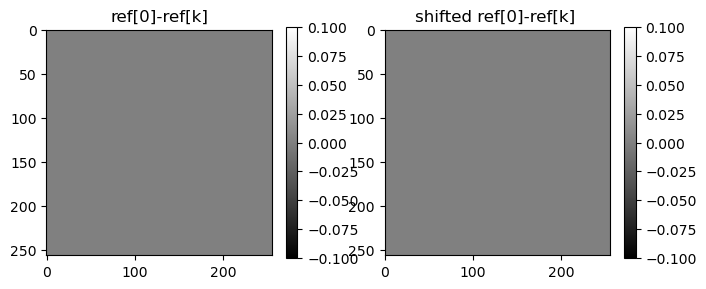

In [8]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im = axs[0].imshow(ref00[0, 0]-ref00[0, k], cmap='gray')
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    # ,vmin=-500,vmax=500)
    im = axs[1].imshow(ref0[0, 0]-ref0[0, k], cmap='gray')
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

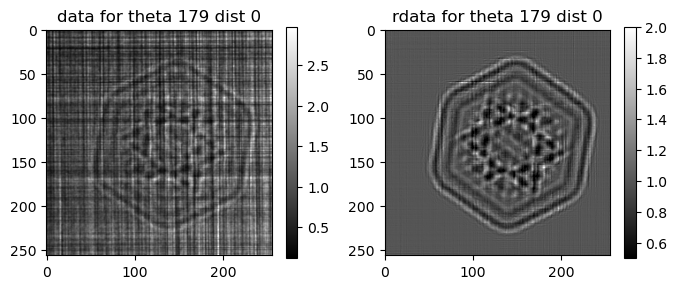

In [9]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im=axs[0].imshow(data0[-1,k],cmap='gray')#,vmin = 0.5,vmax=2 )
    axs[0].set_title(f'data for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[-1,k],cmap='gray',vmin = 0.5,vmax=2)
    axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
    fig.colorbar(im)

### Scale images and shift them based on random shifts

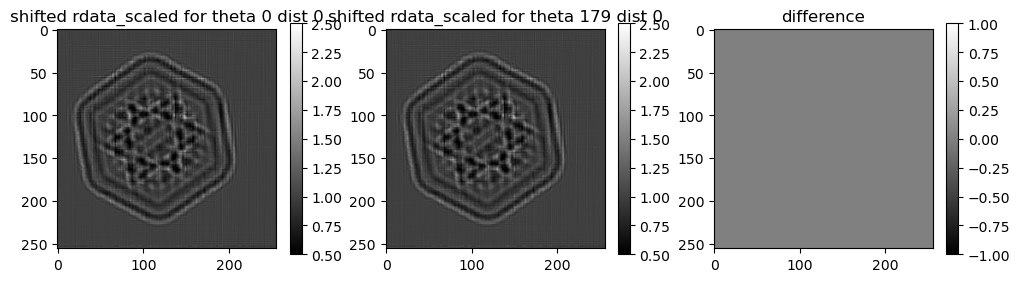

In [10]:
rdata_scaled = rdata.copy()

for k in range(ndist):
    rdata_scaled[:, k] = M(rdata_scaled[:, k], 1 /
                           norm_magnifications[k], n).real
    rdata_scaled[:, k] = ST(rdata_scaled[:, k], shifts[:, k]/norm_magnifications[k]).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    im = axs[0].imshow(rdata_scaled[0, 0], cmap='gray', vmin=0.5, vmax=2.5)
    axs[0].set_title(f'shifted rdata_scaled for theta 0 dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled[0, k], cmap='gray', vmin=0.5, vmax=2.5)
    axs[1].set_title(f'shifted rdata_scaled for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled[0, k]-rdata_scaled[0, 0], cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

### Align images between different planes


#### Approach 2. Align CTF reconstructions from 1 distance

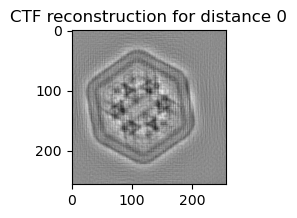

[[0. 0.]] [[0. 0.]]


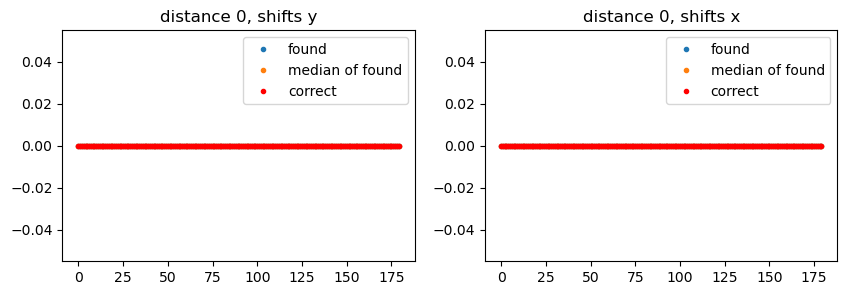

In [11]:
recCTF_1dist = np.zeros([ntheta, ndist, n, n], dtype='float32')
distances_ctf = (distances/norm_magnifications**2)[:ndist]

for k in range(ndist):
    recCTF_1dist[:, k] = CTFPurePhase(
        rdata_scaled[:, k:k+1], distances_ctf[k:k+1], wavelength, voxelsize, 1e-2)

plt.figure(figsize=(2, 2))
plt.title(f'CTF reconstruction for distance {ndist-1}')
plt.imshow(recCTF_1dist[0, -1], cmap='gray')
plt.show()

shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')

for k in range(1, ndist):
    shifts_drift[:, k] = registration_shift(
        recCTF_1dist[:, k], recCTF_1dist[:, 0], upsample_factor=1000)

# note shifts_drift should be after magnification.
shifts_drift *= norm_magnifications[np.newaxis, :, np.newaxis]

shifts_drift_median = shifts_drift.copy()
shifts_drift_median[:] = np.median(shifts_drift, axis=0)

print(shifts_drift_median[0], shifts_drift_init[0])

for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    im = axs[0].plot(shifts_drift[:, k, 0], '.', label='found')
    im = axs[0].plot(shifts_drift_median[:, k, 0],
                     '.', label='median of found')
    im = axs[0].plot(shifts_drift_init[:, k, 0], 'r.', label='correct')
    axs[0].set_title(f'distance {k}, shifts y')
    axs[0].legend()
    im = axs[1].plot(shifts_drift[:, k, 1], '.', label='found')
    im = axs[1].plot(shifts_drift_median[:, k, 1],
                     '.', label='median of found')
    im = axs[1].plot(shifts_drift_init[:, k, 1], 'r.', label='correct')
    axs[1].set_title(f'distance {k}, shifts x')
    axs[1].legend()
    # plt.show()


# set mediam
shifts_drift = shifts_drift_median

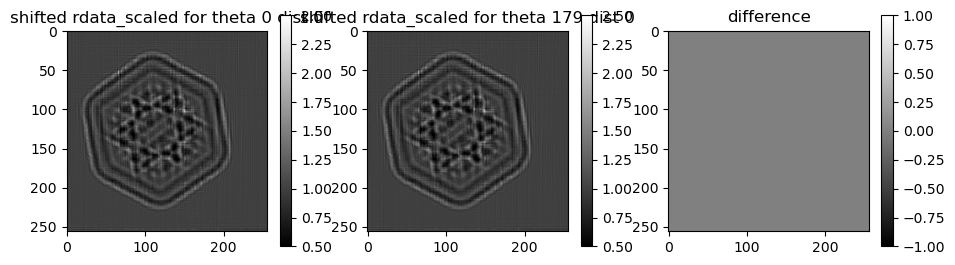

In [12]:
rdata_scaled_aligned = rdata_scaled.copy()
for k in range(ndist):
    rdata_scaled_aligned[:, k] = ST(rdata_scaled[:, k], shifts_drift[:, k]/norm_magnifications[k]).real
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    im = axs[0].imshow(rdata_scaled_aligned[0, 0], cmap='gray', vmin=0.5, vmax=2.5)
    axs[0].set_title(f'shifted rdata_scaled for theta 0 dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled_aligned[0, k], cmap='gray', vmin=0.5, vmax=2.5)
    axs[1].set_title(f'shifted rdata_scaled for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled_aligned[0, k] - rdata_scaled_aligned[0, 0], cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

#### Reconstruction by the MultiPaganin method

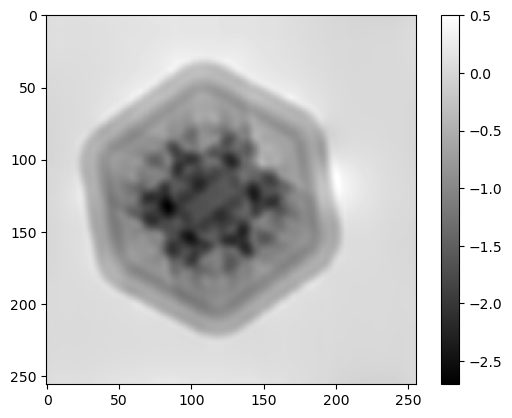

In [13]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = multiPaganin(rdata_scaled_aligned, distances_pag, wavelength, voxelsize, 100, 1e-12)
plt.imshow(recMultiPaganin[0],cmap='gray')
plt.colorbar()

#### Reconstruction by the CTF pure phase method

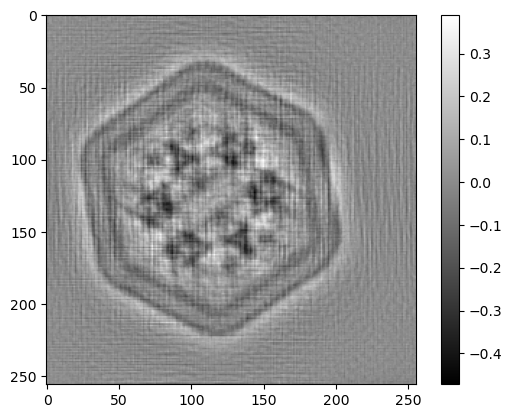

In [16]:
distances_ctf = (distances/norm_magnifications**2)[:ndist]

recCTF = CTFPurePhase(rdata_scaled_aligned, distances_ctf, wavelength, voxelsize, 1e-2)
plt.imshow(recCTF[0],cmap='gray')
plt.colorbar()